Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
fnc_decode_L1.py\
Description: Script for decoding analysis on layer 1 of probabilistic RNN

INPUT\
RNN_params (dict)
   - prob_split: what was the split of the dominant stim vs all (default '70_30')
   - afc: number of alternatives (2 or 6) (default 2)
   - coh: what was the coherence of RDK (default 'hi')
   - feedback: interlayer feedback (true or false) (default false)
   - thresh: the threshold to label RNN output (default [.3, .7])

D_params (dict)
   - time_avg: whether we want decoding averaged over time or not (true or false) (default false)
   - t_win: what time window to average over if time_avg = true (default [200,-1])
   - n_cvs: cross validation folds (default 5)
   - num_cgs: penalties to eval (default 30)
   
plot: whether to save plots or not (true or false) (default false)
    

In [4]:
def fnc_decode_L1(RNN_params, D_params, data, plot):

    #set up defaults
    if RNN_params:
        prob_split = RNN_params['prb_split']
        afc = RNN_params['afc']
        coh = RNN_params['coh']
        feedback = RNN_params['feedback']
        thresh = RNN_params['thresh']
    else:
        prob_split = '70_30'
        afc = 2
        coh = 'hi'
        feedback = False
        thresh = [.3,.7]
        
    if D_params:
        time_avg = D_params['time_avg']
        t_win = D_params['t_win']
        n_cvs = D_params['n_cvs']
        num_cgs = D_params['num_cgs']
    else:
        time_avg = False
        t_win = [200,-1]
        n_cvs = 5
        num_cgs = 30
    
    
    
    
    
    
    
    # store the accuracy
    acc = np.full( ( n_cvs ), np.nan )

    # penalties to eval
    Cs = np.logspace( -5,1, num_cgs )

    # set up the grid
    param_grid = { 'C': Cs, 'kernel': ['linear'] }

    # define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
    # note that can also specify cv folds here, but I'm doing it by hand below in a loop
    grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )


In [5]:
# Data Directory
if sys.platform.startswith('linux'):
    data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{prob_split}_{afc}afc/feedforward_only/{coh}_coh"
else:
    data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{prob_split}_{afc}afc/feedforward_only/{coh}_coh"

# Load data
data = np.load(f"{data_dir}/Trials.npz")
data_expected = np.load(f"{data_dir}/Trials200_0expected.npz")
data_unexpected = np.load(f"{data_dir}/Trials200_1expected.npz")
task_info = {}
task_info['trials'] = 200
task_info['trial_dur'] = 250  # trial duration (timesteps)
task_info['stim_on'] = 80
task_info['stim_dur'] = 50

______________________________________________________________________

## Next: Compare decode expected vs. unexpected
Hypothesis: We can decode expected stimulus better than unexpected because the RNN has acquired the expectation. 

### Decode expected stim input

In [6]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
data_d = data_expected['fr1']
labs = data_expected['labs'].squeeze()

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out

In [7]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        X = data_d[ trn_ind,: ]
        y = labs[trn_ind]

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = labs[trn_ind]

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = labs[tst_ind]

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



Progress: [====================] 1250/1250
done decoding


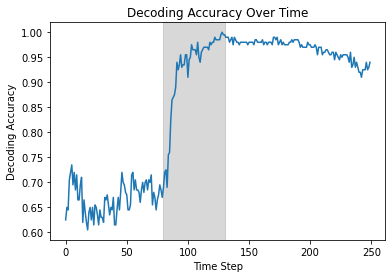

In [9]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_stim_exp.png")
    plt.show()  

Estimated y-value of the asymptote: 0.9678202794816257


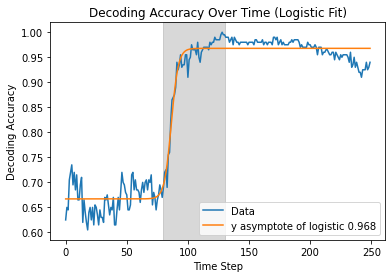

In [10]:
# fit logistic function
def logistic_func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_stim_expfit.png")
plt.show()

### Decode unexpected stim input

In [11]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
data_d = data_unexpected['fr1']
labs = data_unexpected['labs'].squeeze()


In [12]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        X = data_d[ trn_ind,: ]
        y = labs[trn_ind]

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = labs[trn_ind]

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = labs[tst_ind]

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



Progress: [====================] 1250/1250
done decoding


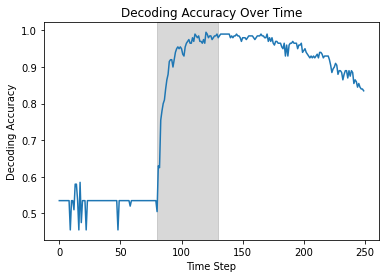

In [13]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_stim_unx.png")
    plt.show()  

Estimated y-value of the asymptote: 0.9488829086214897


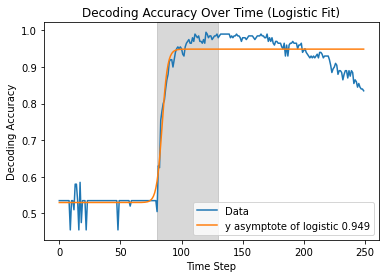

In [14]:
# fit logistic function
popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_stim_unxfit.png")
plt.show()

______________________________________________________________________

______________________________________________________________________

### Decode expected stim choice

In [15]:
# Decode trials: RNN stim choice

# get the data from layer 1 decode choice
# this is a [trial x time step x unit] matrix
data_d = data_expected['fr1']
labs = data_expected['outs'][:,-1]

In [16]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_d[ trn_ind,: ]
        y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)#np.select([labs[trn_ind] >= thresh], [1], default=0) 

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = np.select([labs[tst_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



Progress: [====================] 1250/1250
done decoding


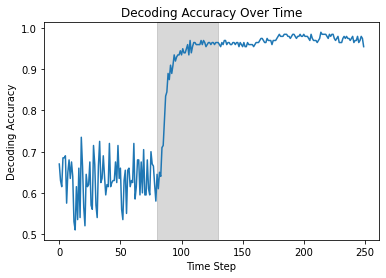

In [17]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_choice_exp.png")
    plt.show() 

Estimated y-value of the asymptote: 0.9680707517292327


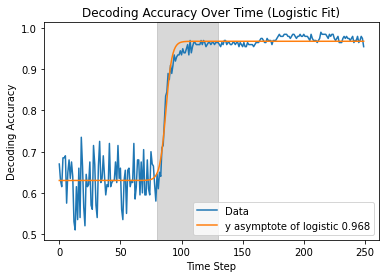

In [18]:
# fit logistic function
popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_choice_expfit.png")
plt.show()

### Decode unexpected stim choice

In [19]:
# Decode trials: RNN stim choice

# get the data from layer 1 decode choice
# this is a [trial x time step x unit] matrix
data_d = data_unexpected['fr1']
labs = data_unexpected['outs'][:,-1]


In [20]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_d[ trn_ind,: ]
        y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)#np.select([labs[trn_ind] >= thresh], [1], default=0) 

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = np.select([labs[tst_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



Progress: [====================] 1250/1250
done decoding


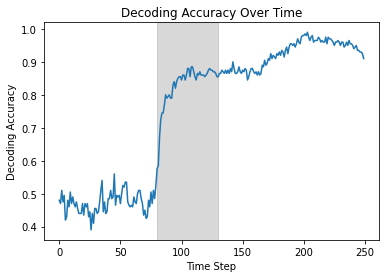

In [21]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_choice_unx.png")
    plt.show() 

Estimated y-value of the asymptote: 0.911966640375667


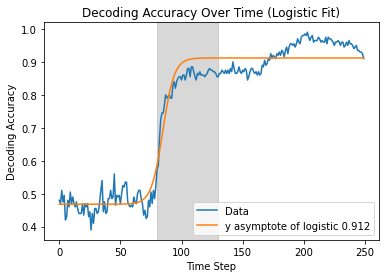

In [22]:
# fit logistic function
popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_choice_unxfit.png")
plt.show()